In [1]:
import yfinance as yf
import matplotlib as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import math
from datetime import date

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras import optimizers

from ipywidgets import IntProgress

Using TensorFlow backend.


In [2]:
tick = yf.Ticker("KO")
stock = tick.history(period='max')
#Only use 4 years of data
today = date.today()
formed_date = today.strftime("%Y-%m-%d")
stock = stock.loc['2015-09-01':formed_date]
stock.tail()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-11-18,52.680000,53.439999,52.669998,53.029999,13782000.0,0.0,0.0
2019-11-19,53.150002,53.310001,52.869999,53.080002,12679500.0,0.0,0.0
2019-11-20,53.099998,53.400002,53.009998,53.220001,11970300.0,0.0,0.0
2019-11-21,53.110001,53.340000,52.779999,52.959999,7856100.0,0.0,0.0
2019-11-22,52.959999,53.187801,52.750000,53.150002,4723311.0,0.0,0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


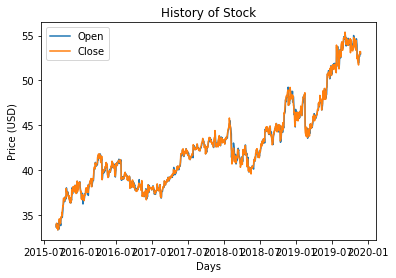

In [3]:
plt.figure()
plt.plot(stock["Open"])
plt.plot(stock["Close"])
plt.title('History of Stock')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'Volume'], loc='upper left')
plt.show()

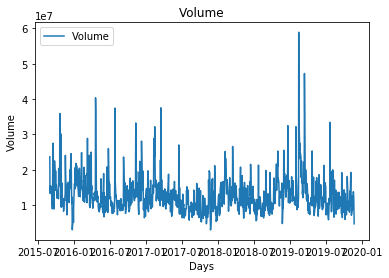

In [4]:
plt.figure()
plt.plot(stock["Volume"])
plt.title('Volume')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.legend(['Volume'], loc='upper left')
plt.show()

In [5]:
#Features
train_cols = ['Open', 'High', 'Close', 'Low', 'Volume']
#Make training set 80% of the data
vti_train, vti_test = train_test_split(stock, train_size=0.8, test_size=0.2, shuffle=False)
x = vti_train.loc[:,train_cols].values
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x)
x_test = scaler.fit_transform(stock.loc[:,train_cols])
print(x[:1])
print(x_train[:1])

[[3.36497674e+01 3.39630319e+01 3.37193832e+01 3.35366467e+01
  2.37032000e+07]]
[[0.0197008  0.02803225 0.02464485 0.0209302  0.55419388]]


In [6]:
#How many days in the past that we want to look at
TIME_STEPS = 5

def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS + i]
        y[i] = mat[TIME_STEPS + i, y_col_index]
    print("Length of time-series i/o", x.shape, y.shape)
    return x, y

def trim_data(mat, batch_size):
    num_rows_dropped = mat.shape[0]%batch_size
    if(num_rows_dropped > 0):
        return mat[:-num_rows_dropped]
    else:
        return mat

In [7]:
BATCH_SIZE = 2

x_t, y_t = build_timeseries(x_train, 3)
print(x_t.shape)
x_t = trim_data(x_t, BATCH_SIZE)
print(x_t.shape)
y_t = trim_data(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_data(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_data(y_temp, BATCH_SIZE), 2)
print(x_test_t.shape)



Length of time-series i/o (847, 5, 5) (847,)
(847, 5, 5)
(846, 5, 5)



Length of time-series i/o (1061, 5, 5) (1061,)
(530, 5, 5)


In [8]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0,
              recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam') 
vti_history = model.fit(x_t, y_t, epochs=30, verbose=2, 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        validation_data=(trim_data(x_val, BATCH_SIZE), trim_data(y_val, BATCH_SIZE)))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 846 samples, validate on 530 samples
Epoch 1/30
 - 2s - loss: 0.0110 - val_loss: 0.4943
Epoch 2/30
 - 2s - loss: 0.0228 - val_loss: 0.3713
Epoch 3/30
 - 2s - loss: 0.0145 - val_loss: 0.1633
Epoch 4/30
 - 2s - loss: 0.0077 - val_loss: 0.0859
Epoch 5/30
 - 2s - loss: 0.0044 - val_loss: 0.0534
Epoch 6/30
 - 2s - loss: 0.0035 - val_loss: 0.0545
Epoch 7/30
 - 2s - loss: 0.0029 - val_loss: 0.0428
Epoch 8/30
 - 2s - loss: 0.0028 - val_loss: 0.0407
Epoch 9/30
 - 2s - loss: 0.0028 - val_loss: 0.0340
Epoch 10/30
 - 2s - loss: 0.0025 - val_loss: 0.0292
Epoch 11/30
 - 2s - loss: 0.0024 - val_loss: 0.0284
Epoch 12/30
 - 2s - loss: 0.0021 - val_loss: 0.0255
Epoch 13/30
 - 2s - loss: 0.0023 - val_loss: 0.0226
Epoch 14/30
 - 2s - loss: 0.0022 - val_loss: 0.0205
Epoch 15/30
 - 2s - 

In [9]:
y_pred = model.predict(trim_data(x_test_t, BATCH_SIZE), batch_size= BATCH_SIZE)
print(x_test_t.shape)
y_pred - y_pred.flatten()
y_test_t = trim_data(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is ", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

(530, 5, 5)
Error is  0.007154007623846256 (530, 1) (530,)
[[0.54500604]
 [0.5472552 ]
 [0.55924916]
 [0.5541378 ]
 [0.55455416]
 [0.5484491 ]
 [0.54838884]
 [0.53660595]
 [0.53391194]
 [0.5427922 ]
 [0.53634167]
 [0.52886254]
 [0.52872366]
 [0.52424395]
 [0.52370256]]
[0.45865442 0.46772047 0.46469853 0.46815205 0.46642518 0.46426675
 0.45217895 0.45131533 0.46383509 0.45045179 0.44656638 0.44742996
 0.43836399 0.44354448 0.45088373]


In [10]:
#3 being the amount of y_cols
y_pred_org = (y_pred * scaler.data_range_[3] + scaler.data_min_[3])
y_test_org_t = (y_test_t * scaler.data_range_[3] + scaler.data_min_[3])

print(y_pred_org.shape)
print(y_test_org_t.shape)

(530, 1)
(530,)


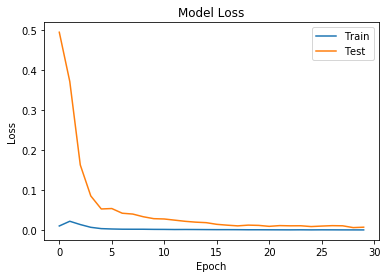

In [11]:
plt.figure()
plt.plot(vti_history.history['loss'])
plt.plot(vti_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])

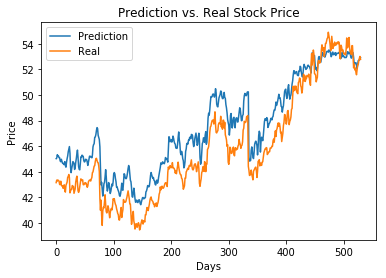

In [12]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_org_t)
plt.title('Prediction vs. Real Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(['Prediction', 'Real'])
plt.savefig("charts/XXIIStock.png")
plt.show()

In [13]:
next_pred = stock[-7:]
#Features
train_cols = ['Open', 'High', 'Close', 'Low', 'Volume']
x_pred_values = next_pred.loc[:,train_cols].values
predx = scaler.fit_transform(x_pred_values)
x_fut, y_fut = build_timeseries(predx, 3)

y_test_t = trim_data(y_test_t, BATCH_SIZE)

future_pred = model.predict(trim_data(x_fut, BATCH_SIZE), batch_size= BATCH_SIZE)

future_pred - future_pred.flatten()
y_fut = trim_data(y_fut, BATCH_SIZE)

fut_pred_org = (future_pred * scaler.data_range_[3] + scaler.data_min_[3])
y_fut = (y_fut * scaler.data_range_[3] + scaler.data_min_[3])

print(next_pred)
print(y_fut)
print(fut_pred_org)
fut_pred_org[0][-1]


Length of time-series i/o (2, 5, 5) (2,)
                 Open       High        Low      Close      Volume  Dividends  \
Date                                                                            
2019-11-14  52.529999  52.669998  52.349998  52.630001   8660300.0        0.0   
2019-11-15  52.639999  52.680000  52.380001  52.669998   8982400.0        0.0   
2019-11-18  52.680000  53.439999  52.669998  53.029999  13782000.0        0.0   
2019-11-19  53.150002  53.310001  52.869999  53.080002  12679500.0        0.0   
2019-11-20  53.099998  53.400002  53.009998  53.220001  11970300.0        0.0   
2019-11-21  53.110001  53.340000  52.779999  52.959999   7856100.0        0.0   
2019-11-22  52.959999  53.187801  52.750000  53.150002   4723311.0        0.0   

            Stock Splits  
Date                      
2019-11-14           0.0  
2019-11-15           0.0  
2019-11-18           0.0  
2019-11-19           0.0  
2019-11-20           0.0  
2019-11-21           0.0  
2019-11-22  

52.9759